# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from umap import UMAP
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import re
from transformers import BertTokenizer, BertModel
import torch

import warnings
warnings.filterwarnings('ignore')

# Эмбеддинги текстов

Загружаем отзывы о фильмах

In [164]:
imdb_data=pd.read_csv('IMDB Dataset.csv').sample(1200)
imdb_data

review sentiment
15962  <br /><br />In Japan and elsewhere in Europe n...  negative
2505   Aaah...The Thing.<br /><br />To see a horror f...  positive
35633  Monster of Mexico I do agree is the weakest of...  positive
6595   I don't remember too much about this movie exc...  negative
44648  This is a horrible little film--and unfortunat...  negative
...                                                  ...       ...
7836   The book "The Railway Children" is a children'...  positive
5429   AKA: Mondays In The Sun<br /><br />I have no i...  negative
31034  Low-budget but memorable would-be shocker that...  positive
16115  Yes, this film gets a lot of attention and is ...  negative
16882  The plot and characters are ridiculous and bar...  negative

[1200 rows x 2 columns]

Удалим html теги и скобки

In [165]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

imdb_data['review']=imdb_data['review'].apply(denoise_text)

Удалим все символы, кроме букв и цифр

In [166]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

Стемминг

In [167]:
def simple_stemmer(text):
    ps = PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

Удаление стоп слов

In [168]:
stop=set(stopwords.words('english'))
tokenizer=ToktokTokenizer()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

Разделение на train test

In [169]:
norm_train_reviews=imdb_data.review[:1000]
norm_test_reviews=imdb_data.review[1000:]

In [170]:
tokenized_train_reviews = [review.split() for review in norm_train_reviews]
tokenized_test_reviews = [review.split() for review in norm_test_reviews]

Закодируем позитивные и негативные оценки как 1 и 0 и разделим на train test

In [171]:
lb=LabelBinarizer()

sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

train_sentiments=sentiment_data[:1000]
test_sentiments=sentiment_data[1000:]

(1200, 1)


## 1) Bag of Words (BOW)

In [172]:
cv = CountVectorizer()

cv_train_reviews = cv.fit_transform(norm_train_reviews).toarray()
cv_test_reviews = cv.transform(norm_test_reviews).toarray()

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (1000, 15936)
BOW_cv_test: (200, 15936)


## 2) Term Frequency-Inverse Document Frequency model (TFIDF)

In [173]:
tv = TfidfVectorizer()

tv_train_reviews = tv.fit_transform(norm_train_reviews).toarray()
tv_test_reviews = tv.transform(norm_test_reviews).toarray()

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (1000, 15936)
Tfidf_test: (200, 15936)


## 3) Word2Vec

In [174]:
word2vec_model = Word2Vec(sentences=tokenized_train_reviews, vector_size=256, window=5, min_count=1)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")  # Инициализируем вектор нулями
    nwords = 0.  # Счетчик слов
    
    # Для каждого слова в списке слов
    for word in words:

        if word in vocabulary:
            nwords = nwords + 1.  # Увеличиваем счетчик слов
            # Добавляем вектор слова к общему вектору
            feature_vector = np.add(feature_vector, model.wv[word])
    
    # Если в тексте есть хотя бы одно слово из словаря
    if nwords:
        # Усредняем вектор, деля сумму на количество слов
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


train_word2vec_arrays = np.zeros((len(tokenized_train_reviews), 256))
test_word2vec_arrays = np.zeros((len(tokenized_test_reviews), 256))

for i in range(len(tokenized_train_reviews)):
    # Получаем усредненный вектор для текущего отзыва и сохраняем его в соответствующий массив
    train_word2vec_arrays[i] = average_word_vectors(tokenized_train_reviews[i], model=word2vec_model, vocabulary=word2vec_model.wv.key_to_index, num_features=256)

for i in range(len(tokenized_test_reviews)):
    # Получаем усредненный вектор для текущего отзыва и сохраняем его в соответствующий массив
    test_word2vec_arrays[i] = average_word_vectors(tokenized_test_reviews[i], model=word2vec_model, vocabulary=word2vec_model.wv.key_to_index, num_features=256)

print('w2v_train:',train_word2vec_arrays.shape)
print('w2v_test:',test_word2vec_arrays.shape)

w2v_train: (1000, 256)
w2v_test: (200, 256)


## 4) FastText

In [175]:
# Обучение модели FastText
fasttext_model = FastText(sentences=tokenized_train_reviews, vector_size=256, window=5, min_count=1, workers=4, sg=1)

# Создание векторов FastText для обучающего и тестового наборов
train_fasttext_arrays = np.zeros((len(tokenized_train_reviews), 256))
test_fasttext_arrays = np.zeros((len(tokenized_test_reviews), 256))

# Для каждого отзыва в обучающем наборе
for i in range(len(tokenized_train_reviews)):
    # Получаем вектор для текущего отзыва и сохраняем его в соответствующий массив
    train_fasttext_arrays[i] = np.mean([fasttext_model.wv[token] for token in tokenized_train_reviews[i] if token in fasttext_model.wv], axis=0)

# Для каждого отзыва в тестовом наборе
for i in range(len(tokenized_test_reviews)):
    # Получаем вектор для текущего отзыва и сохраняем его в соответствующий массив
    test_fasttext_arrays[i] = np.mean([fasttext_model.wv[token] for token in tokenized_test_reviews[i] if token in fasttext_model.wv], axis=0)

print('ft_train:',train_fasttext_arrays.shape)
print('ft_test:',test_fasttext_arrays.shape)

ft_train: (1000, 256)
ft_test: (200, 256)


## Практическое сравнение эмбеддингов

In [176]:
## Результаты
lr = LogisticRegression()

# Logistic Regression на Bag of Words (CountVectorizer)
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
lr_bow_predict = lr.predict(cv_test_reviews)
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("BOW accuracy:", lr_bow_score)

# Logistic Regression на TF-IDF (TfidfVectorizer)
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
lr_tfidf_predict = lr.predict(tv_test_reviews)
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("TF-IDF accuracy:", lr_tfidf_score)

# Logistic Regression на Word2Vec
lr_word2vec = lr.fit(train_word2vec_arrays, train_sentiments)
lr_word2vec_predict = lr_word2vec.predict(test_word2vec_arrays)
lr_word2vec_score = accuracy_score(test_sentiments, lr_word2vec_predict)
print("Word2Vec accuracy:", lr_word2vec_score)

# Logistic Regression на FastText
lr_fasttext = lr.fit(train_fasttext_arrays, train_sentiments)
lr_fasttext_predict = lr_fasttext.predict(test_fasttext_arrays)
lr_fasttext_score = accuracy_score(test_sentiments, lr_fasttext_predict)
print("FastText accuracy:", lr_fasttext_score)

BOW accuracy: 0.82
TF-IDF accuracy: 0.85
Word2Vec accuracy: 0.6
FastText accuracy: 0.61


# Визуализация эмбеддингов текстов

In [177]:
emb_list = [cv_train_reviews, tv_train_reviews, train_word2vec_arrays, train_fasttext_arrays]
names_list = ['BoW', 'TF-IDF', 'word2vec', 'FastText']
emb_dict = dict(zip(names_list, emb_list))

In [178]:
def plot_3d(data_dict, axs, title):
    for i, (name, result) in enumerate(data_dict.items()):
        ax = axs.flat[i]
        
        ax.scatter(result[:, 0], result[:, 1], result[:, 2], c=train_sentiments)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        ax.set_title(f'{title} ({name})')
    plt.show()

def plot_hist(data_dict, axes):
    colors = ['skyblue', 'salmon', 'green']
    for i, (embedding_type, tr_data) in enumerate(data_dict.items()):
        for j, color in enumerate(colors):
            sns.histplot(tr_data[:, j], bins=30, ax=axes[i, j], color=color, kde=True)
            axes[i, j].set_title(f'Гистограмма компоненты {j+1} ({embedding_type})')
            axes[i, j].set_xlabel(f'Значение компоненты {j+1}')
            axes[i, j].set_ylabel('Плотность')
    plt.tight_layout()
    plt.show()

## 1) Principal component analysis (PCA)

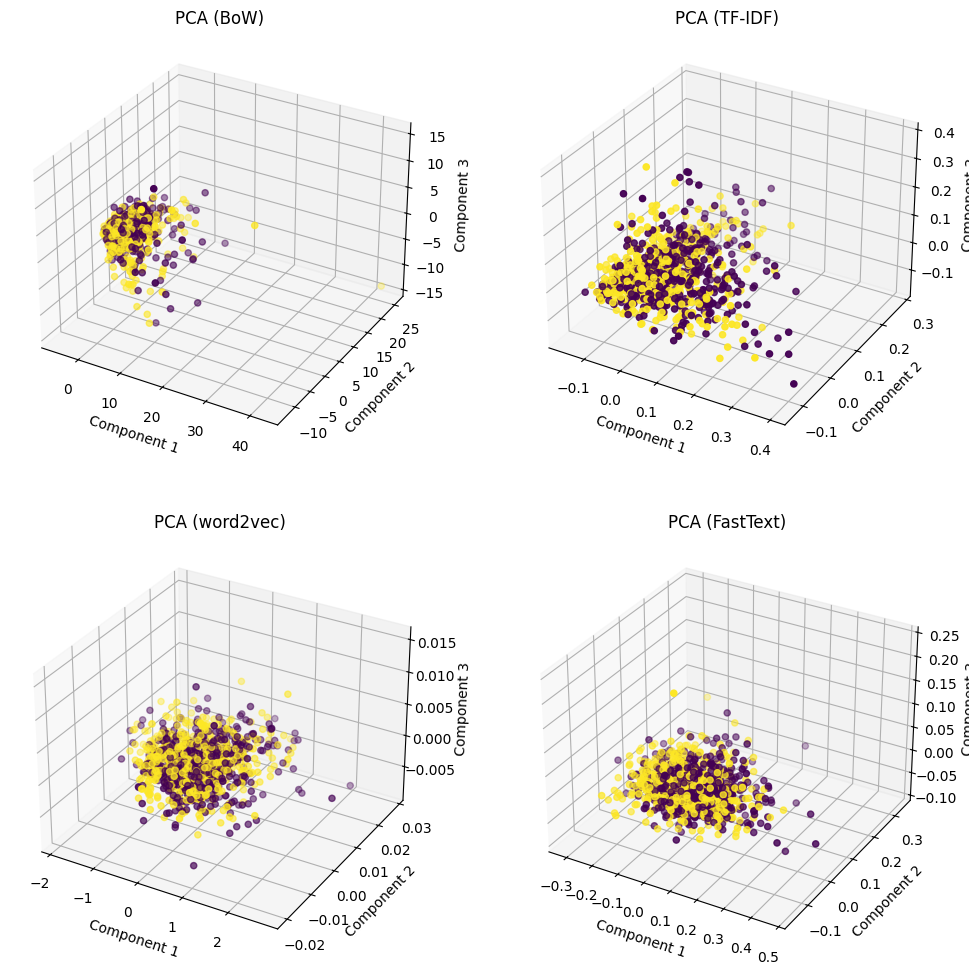

In [179]:
pca_dict = {name: PCA(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(pca_dict, axs, 'PCA')

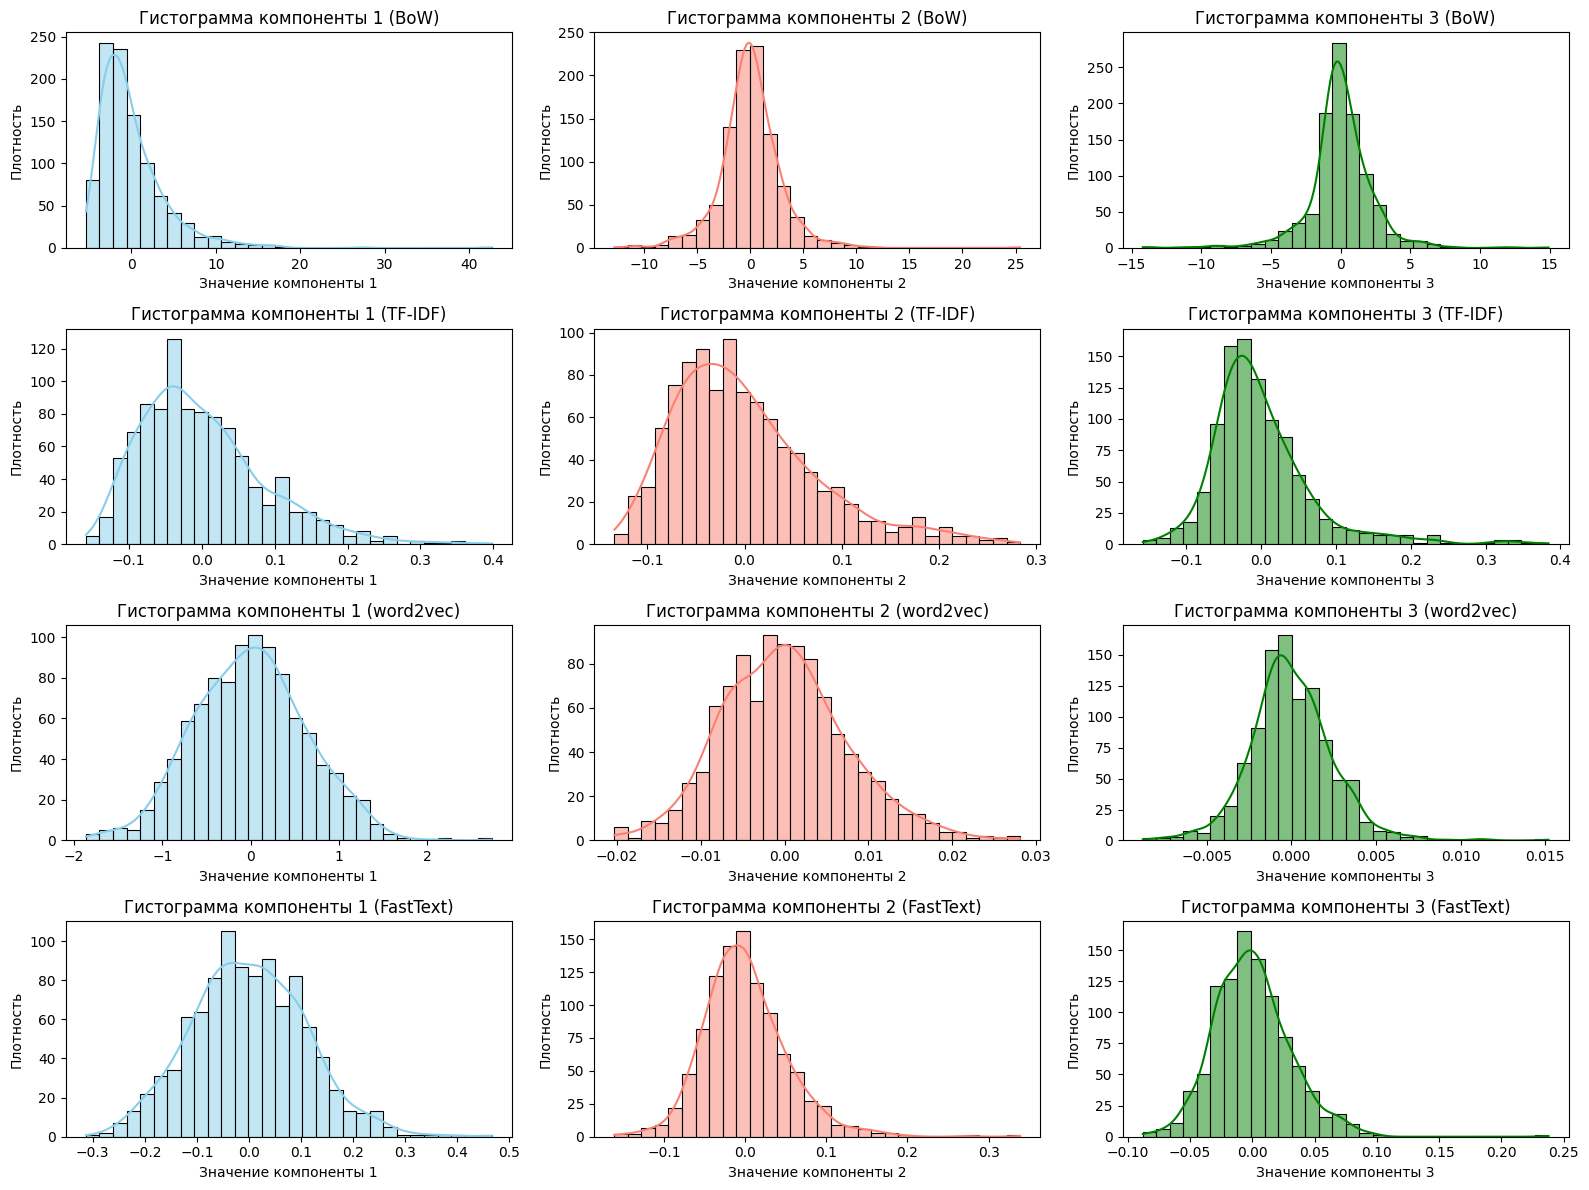

In [180]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(pca_dict, axs)

## 2) t-Distributed Stochastic Neighbor Embedding (t-SNE)

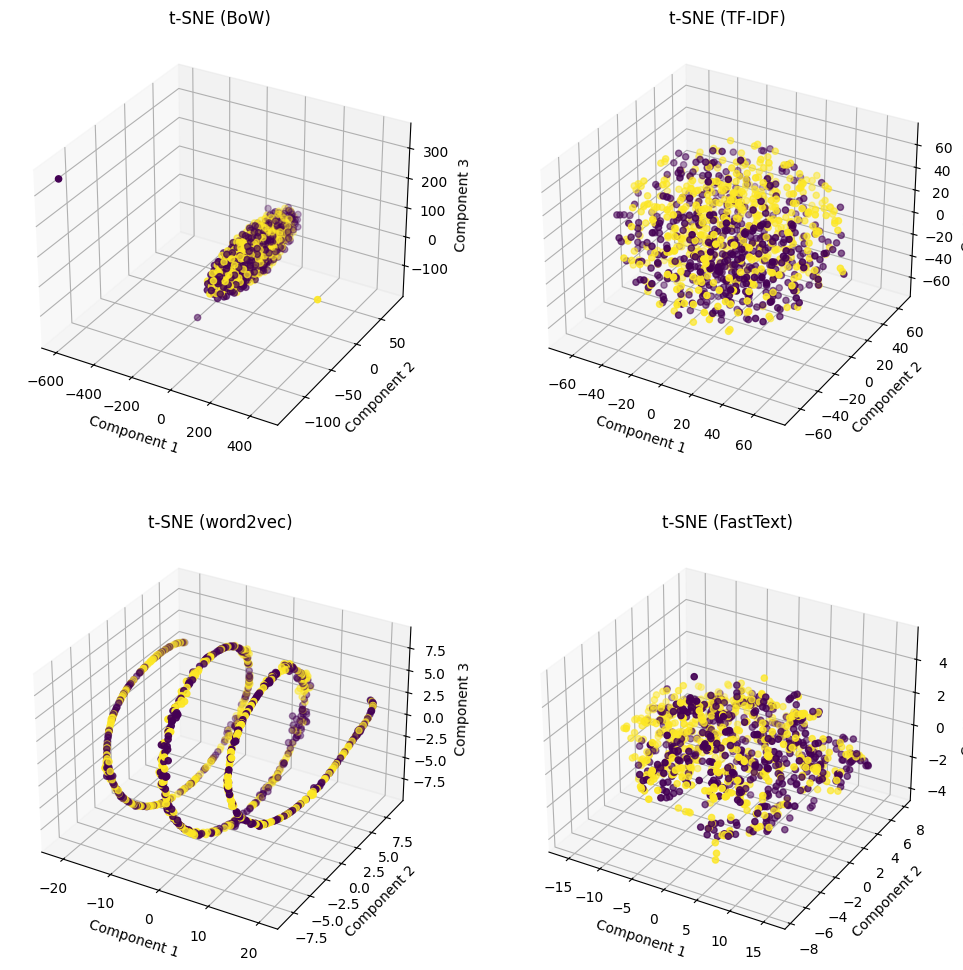

In [181]:
tsne_dict = {name: TSNE(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(tsne_dict, axs, 't-SNE')

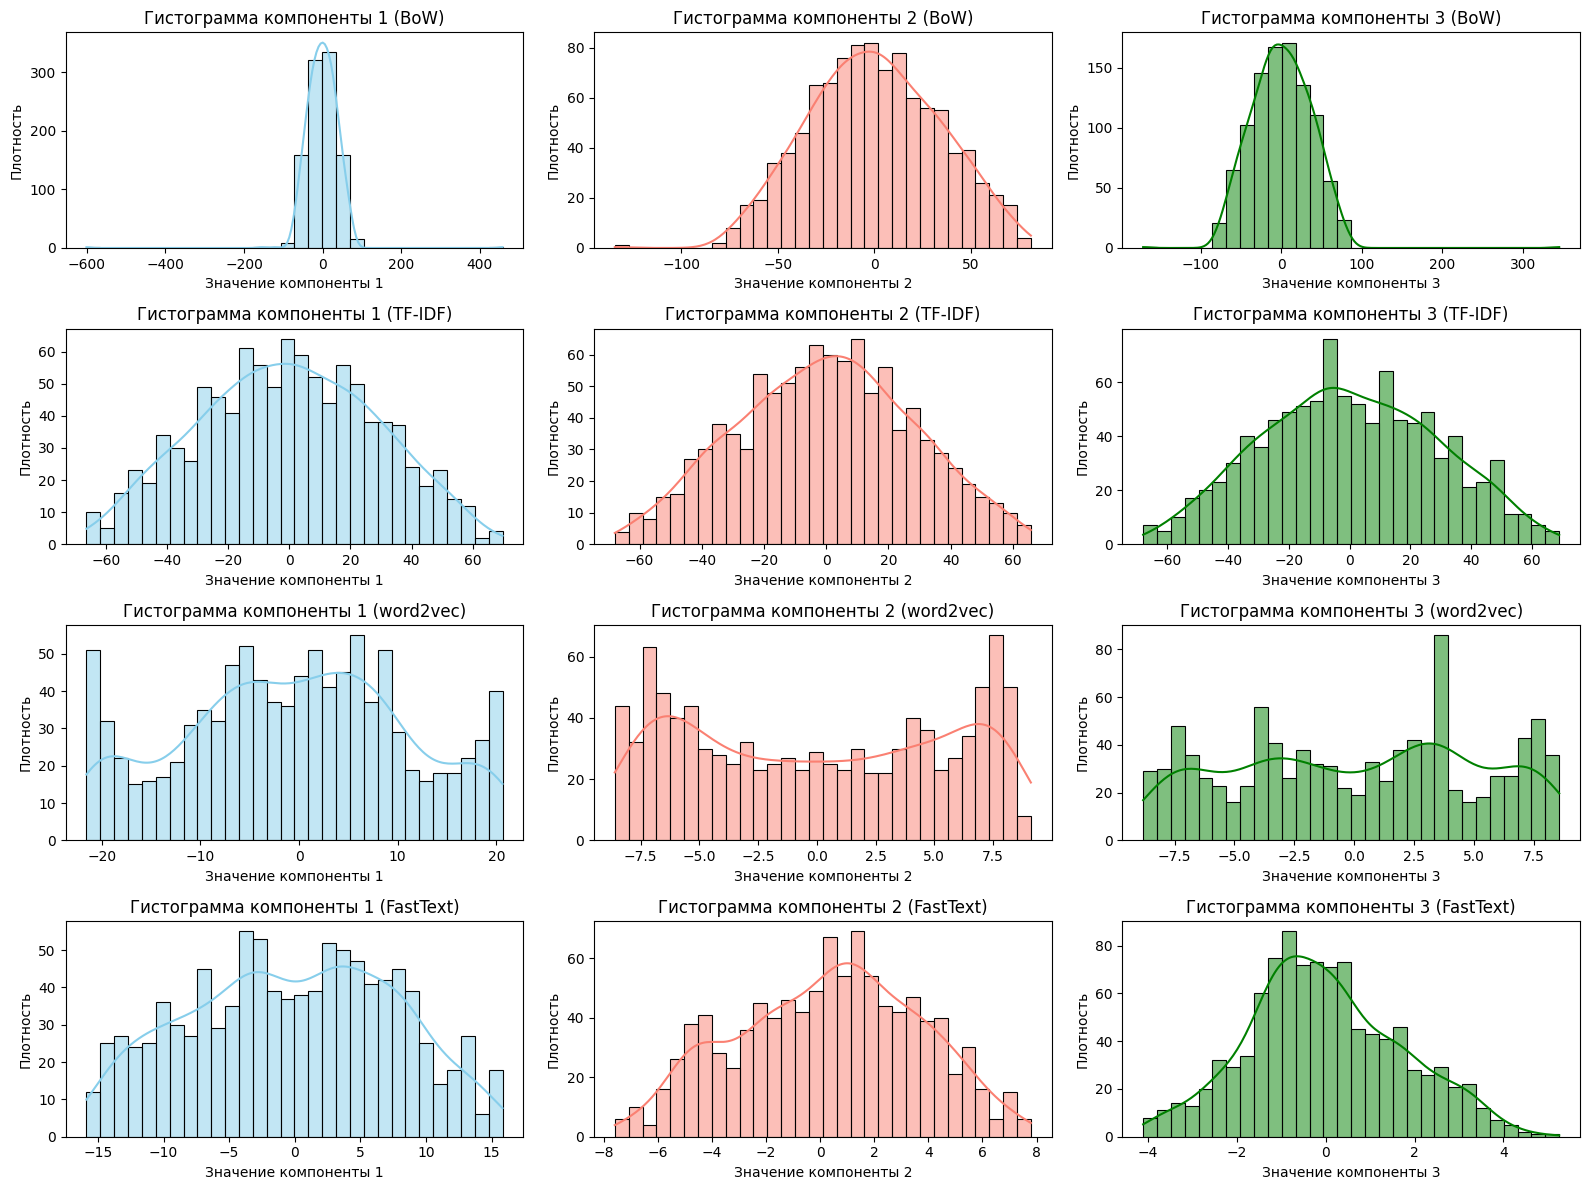

In [182]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(tsne_dict, axs)

## 3) Multidimensional Scaling (MDS)

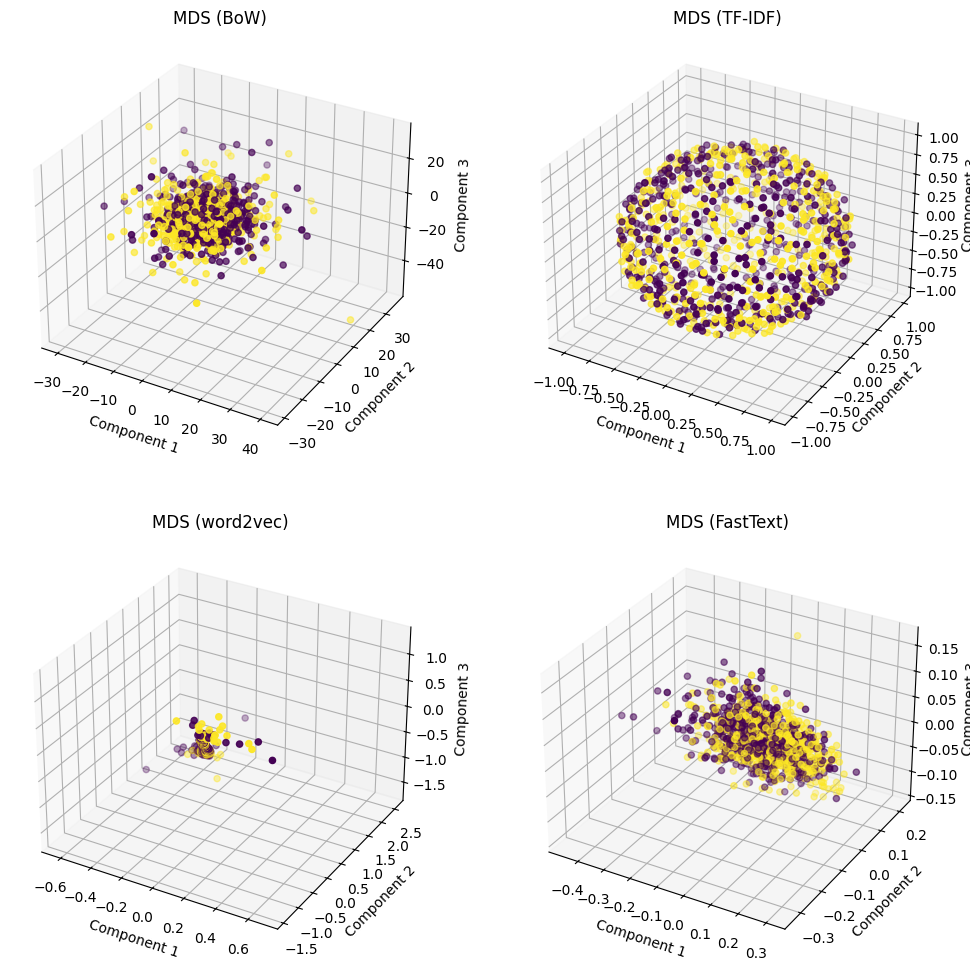

In [183]:
mds_dict = {name: MDS(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(mds_dict, axs, 'MDS')

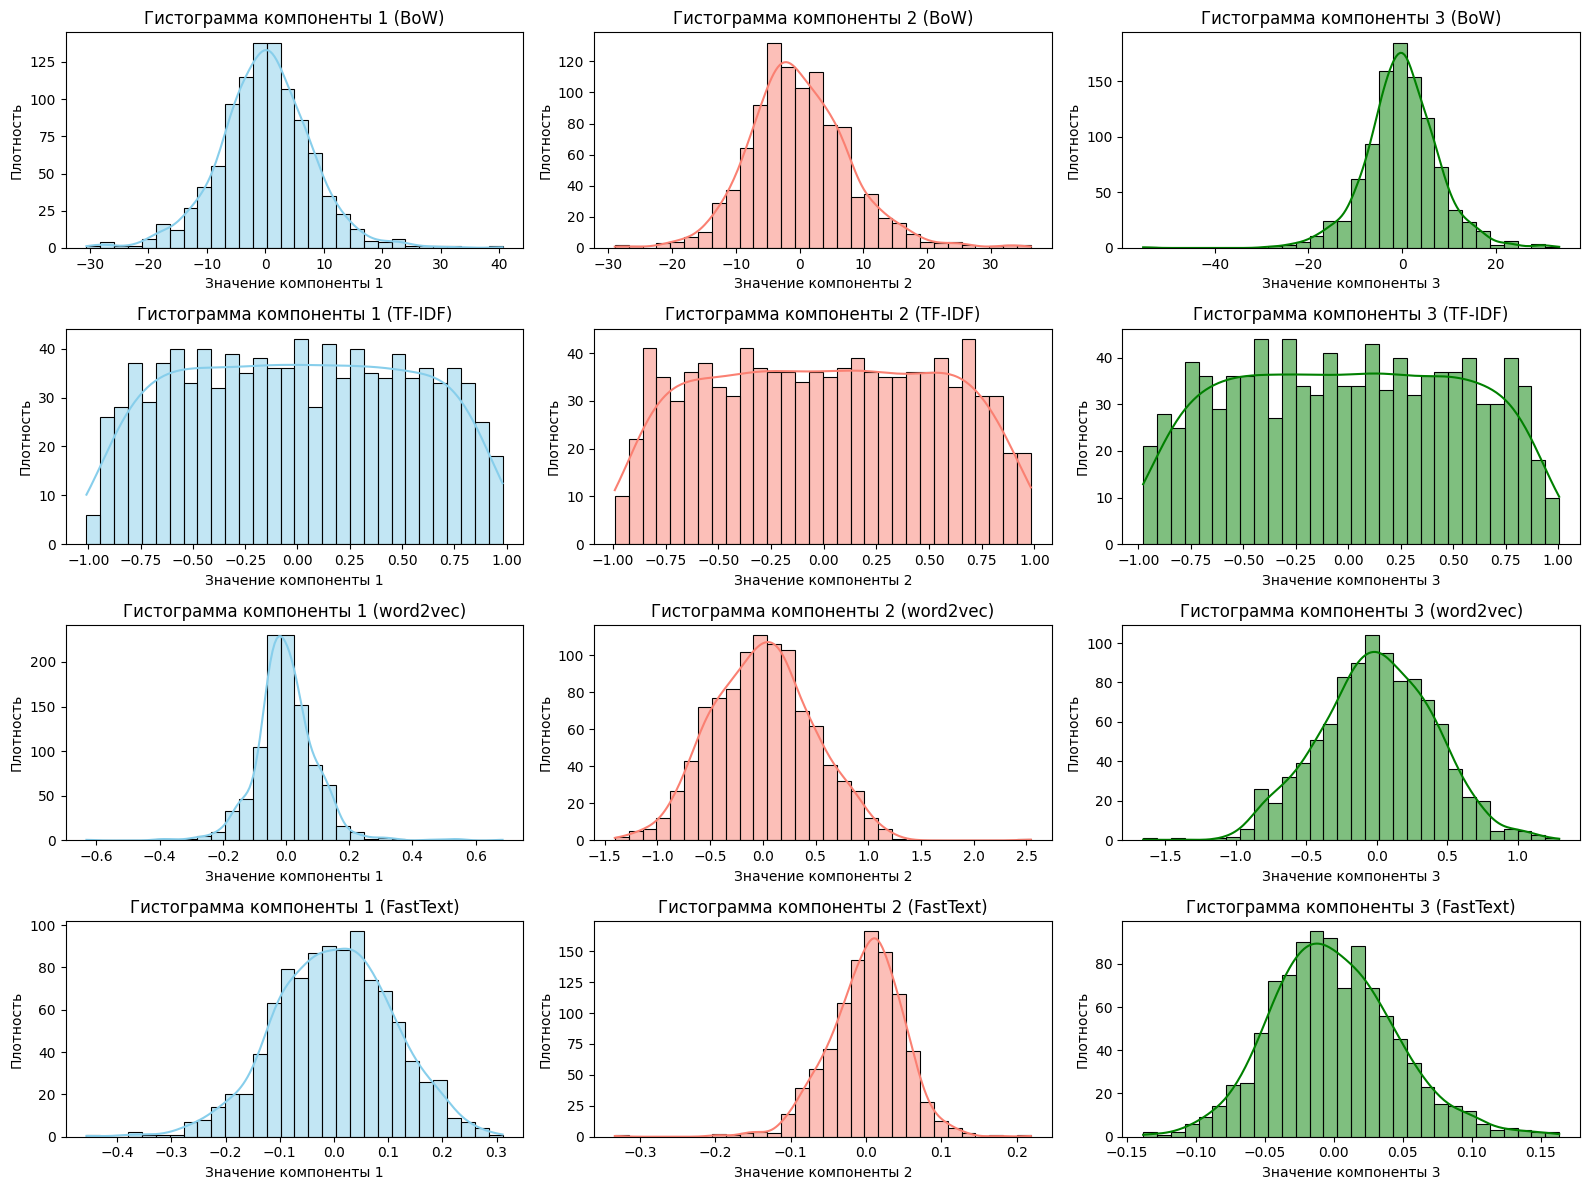

In [184]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(mds_dict, axs)

## 4) Uniform Manifold Approximation and Projection (UMAP)

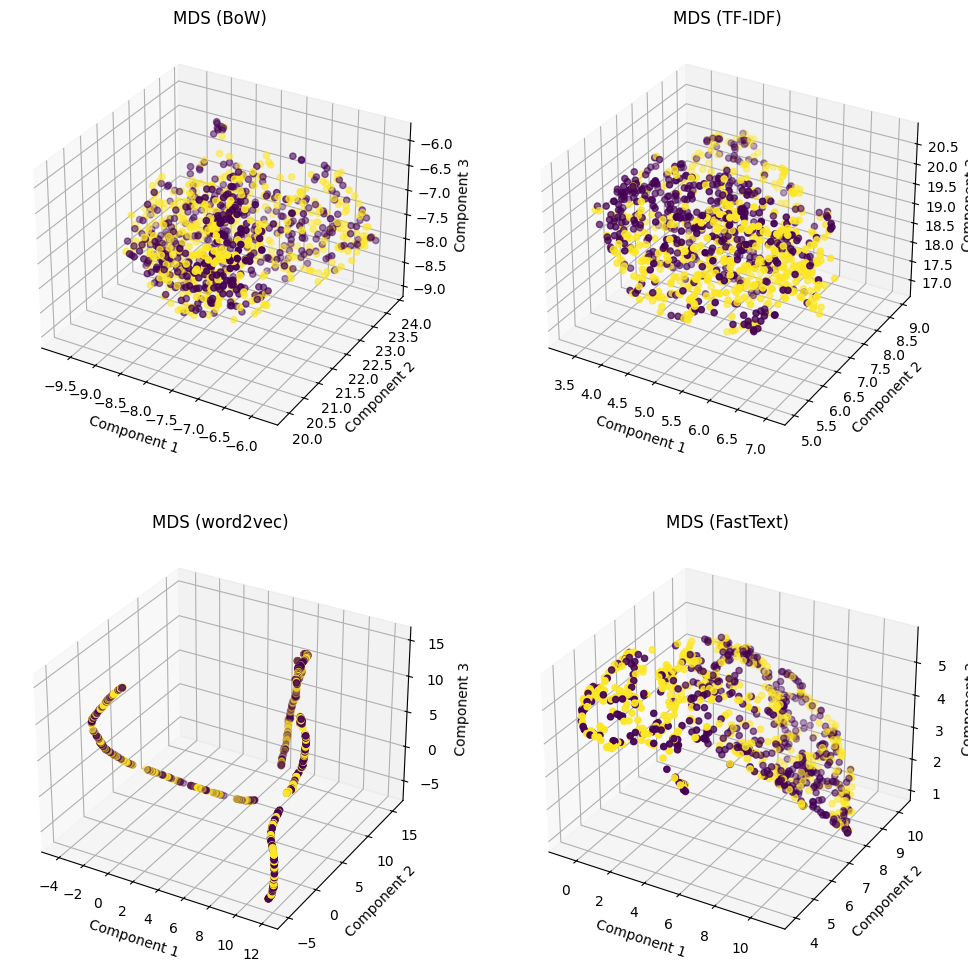

In [185]:
umap_dict = {name: UMAP(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(umap_dict, axs, 'MDS')

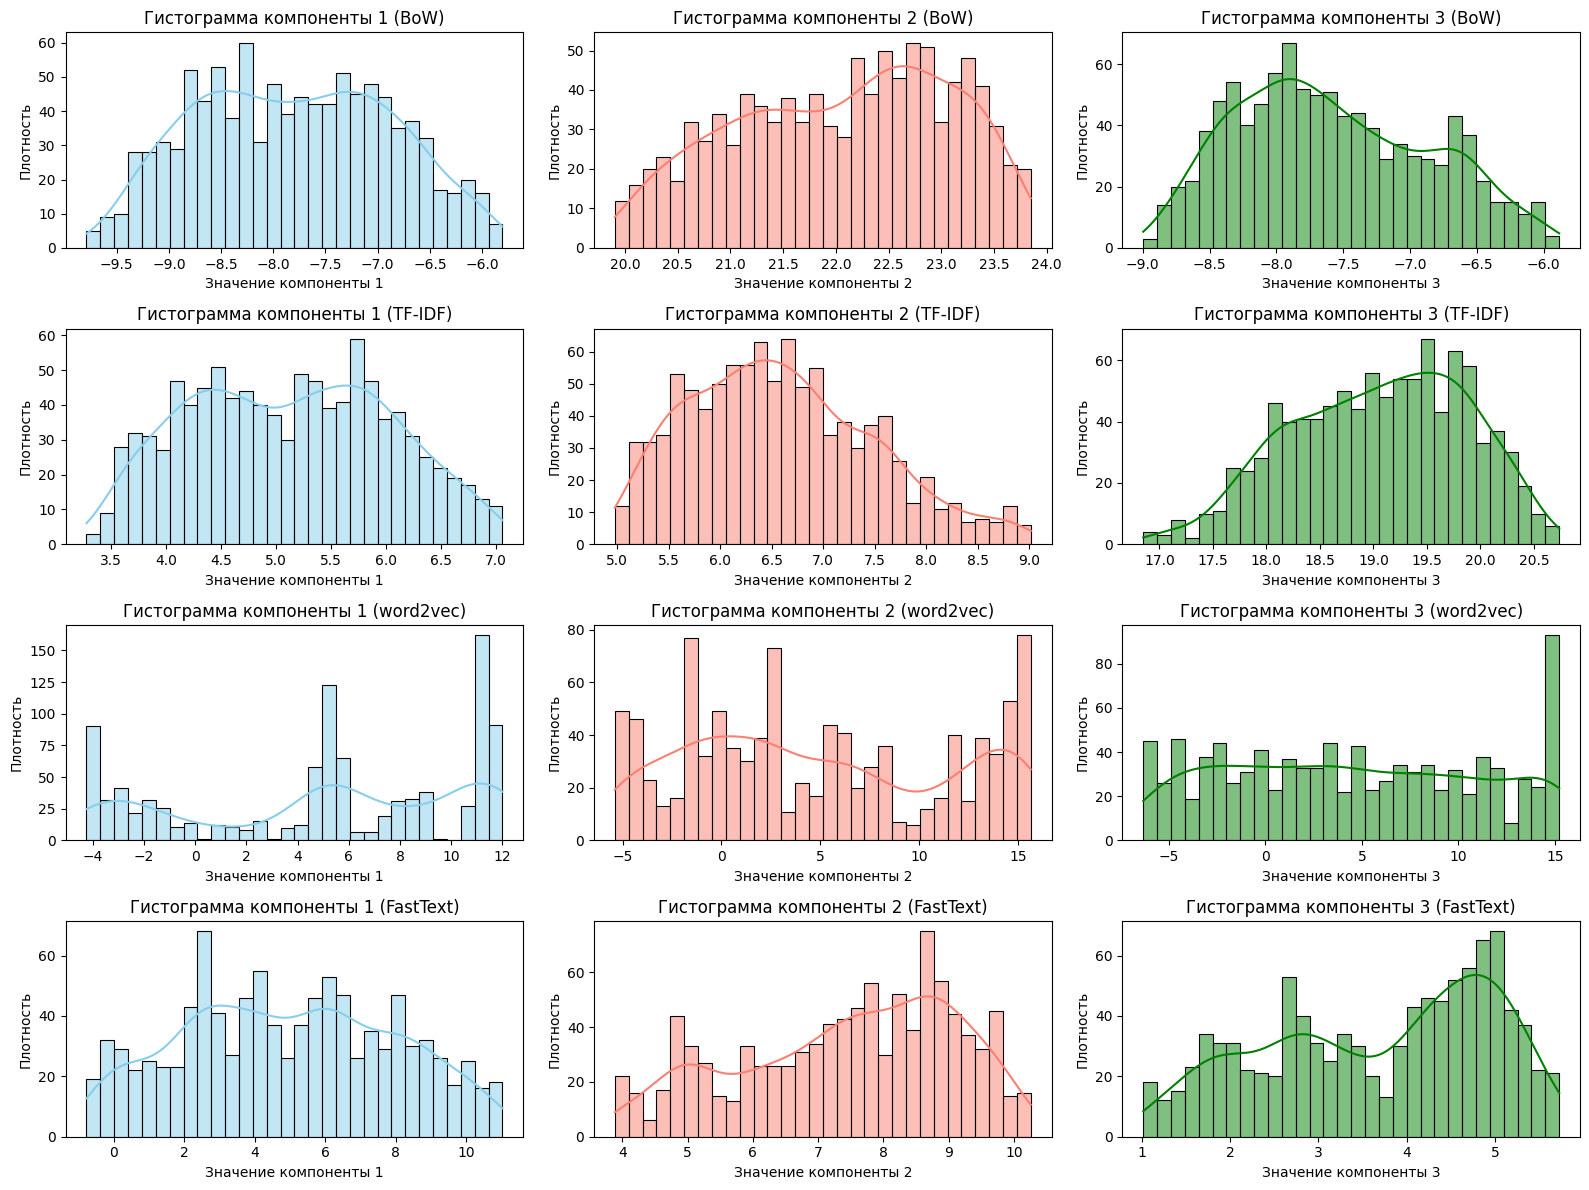

In [186]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(umap_dict, axs)

## 5) Isometric Mapping

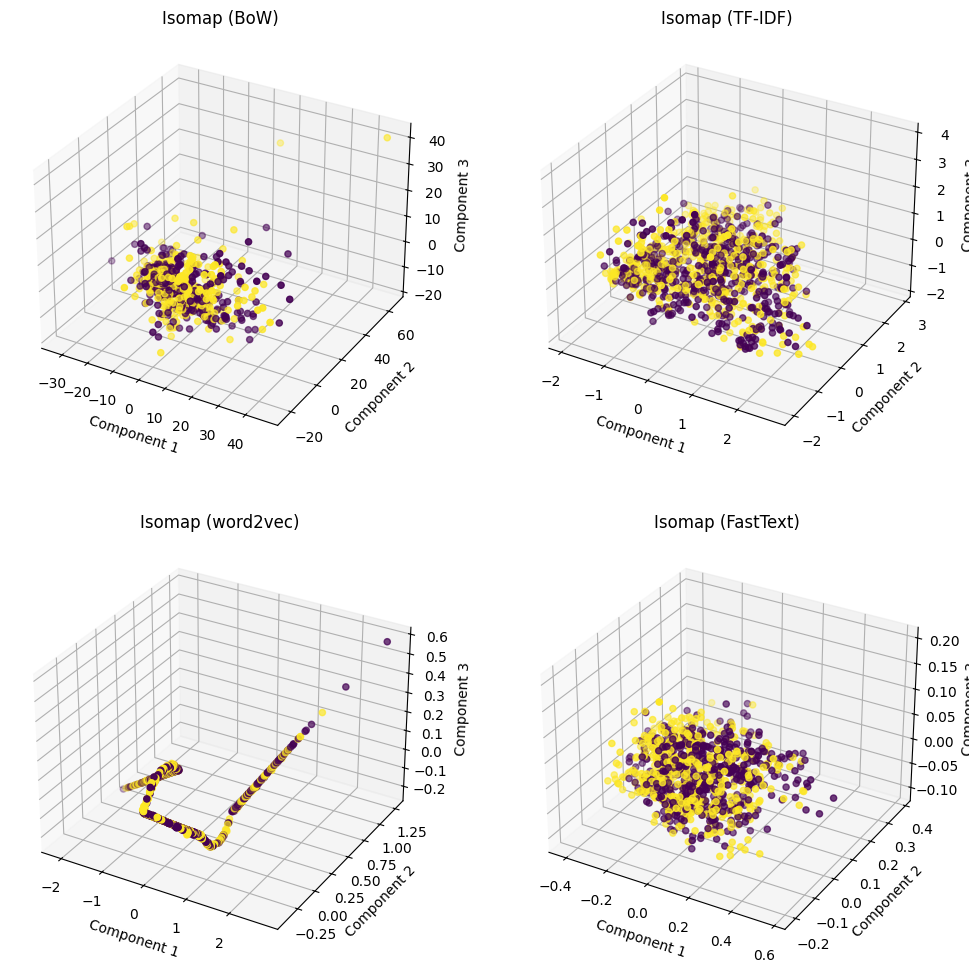

In [187]:
isomap_dict = {name: Isomap(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(isomap_dict, axs, 'Isomap')

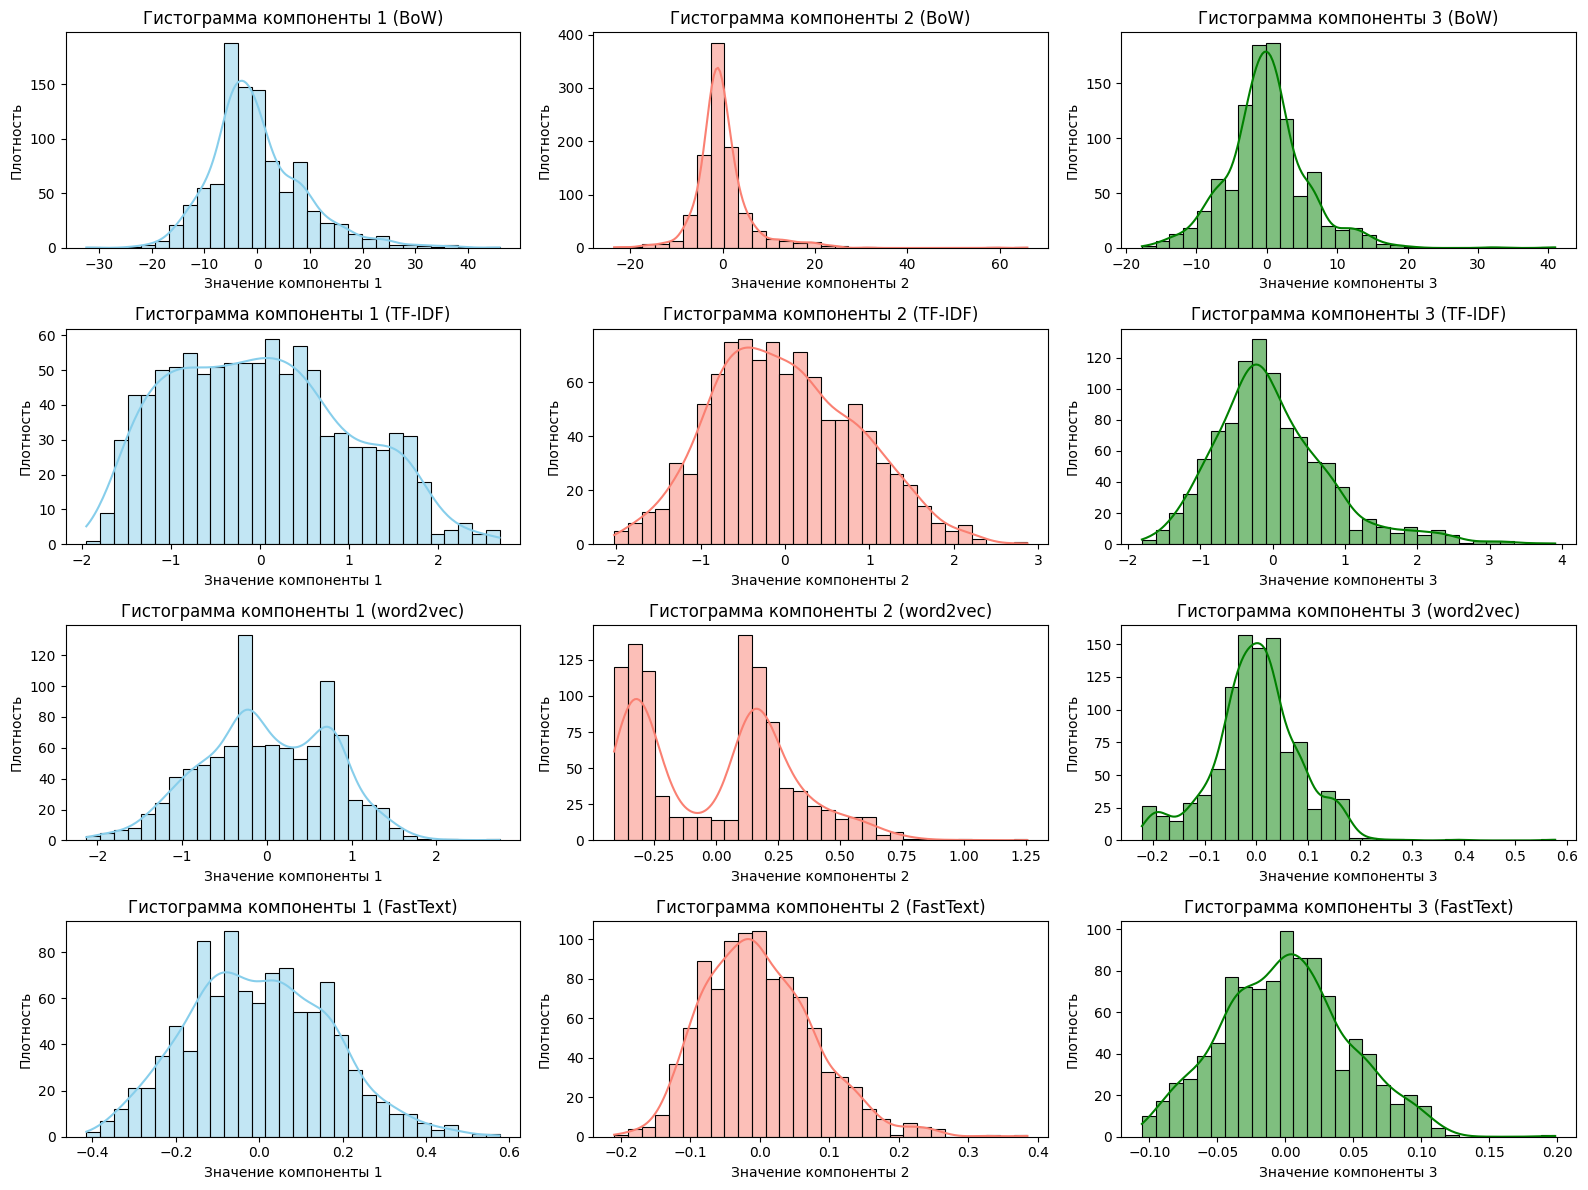

In [188]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(isomap_dict, axs)

## 6) Locally Linear Embedding (LLE)

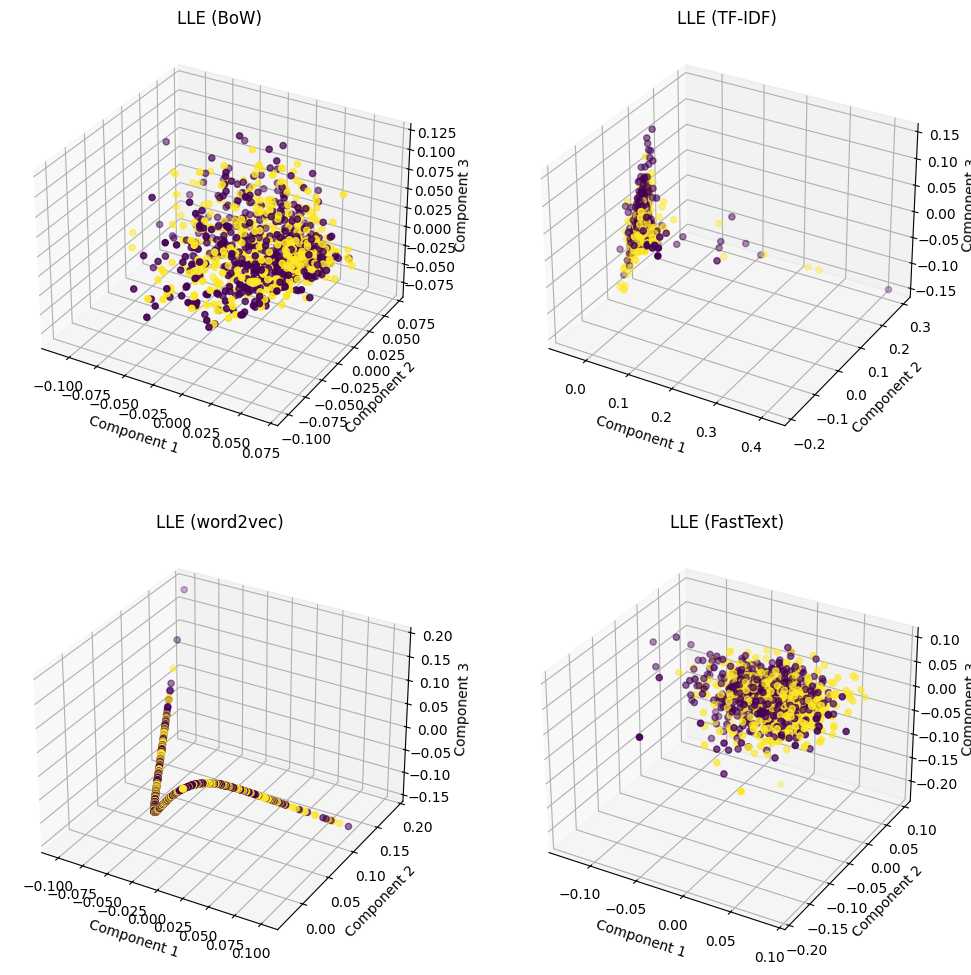

In [189]:
lle_dict = {name: LocallyLinearEmbedding(n_components=3, n_neighbors=50).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(lle_dict, axs, 'LLE')

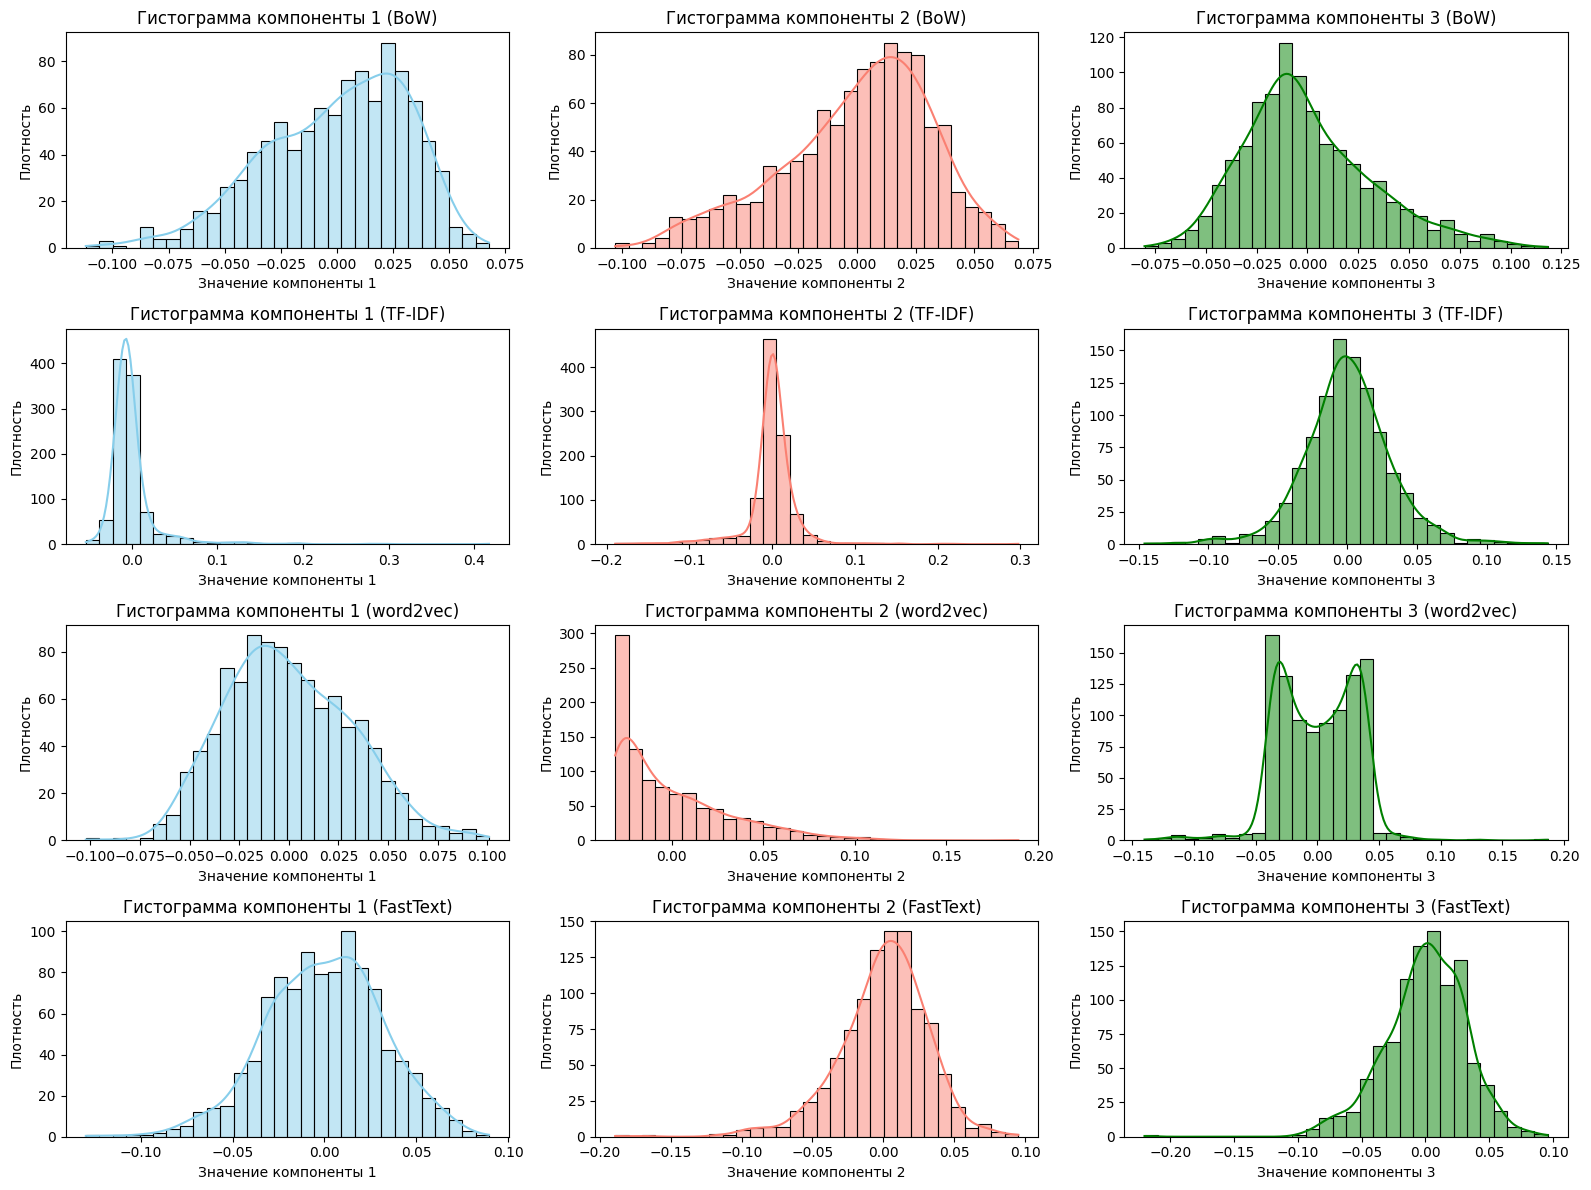

In [190]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(lle_dict, axs)

## 7) Hessian Eigenmapping (Hessian-based LLE: HLLE)

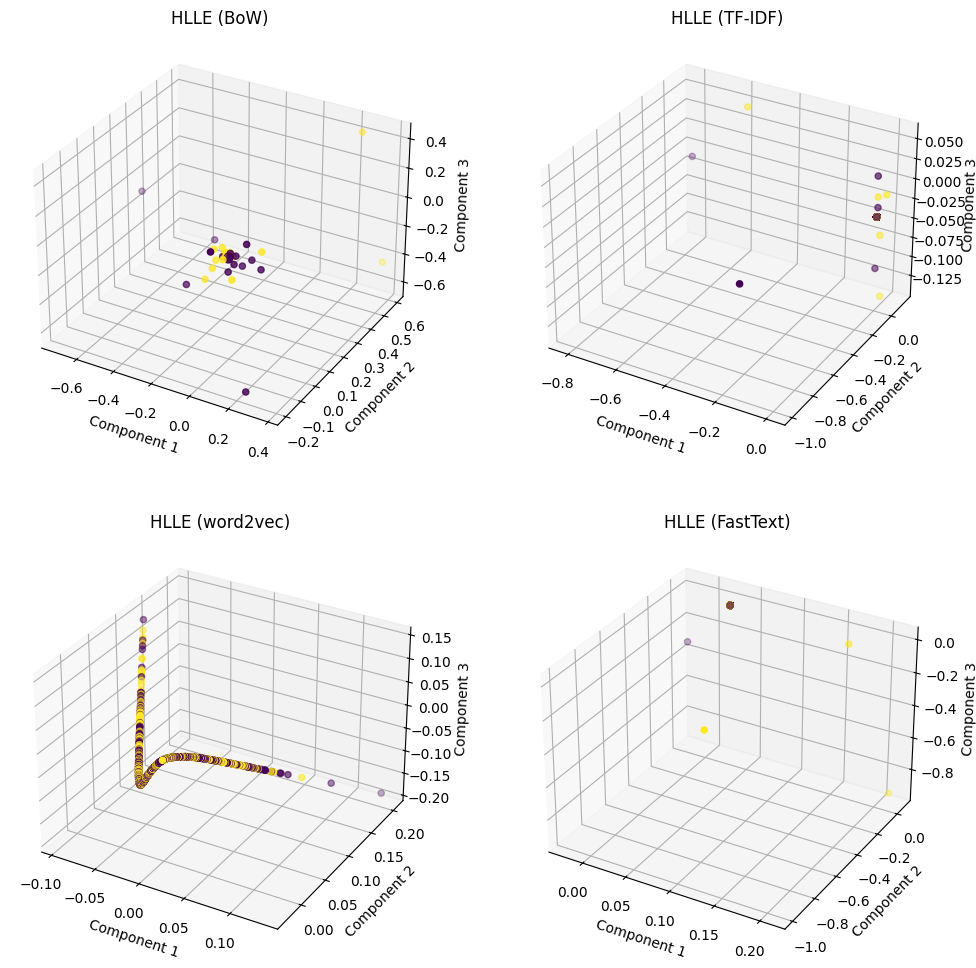

In [191]:
hlle_dict = {name: LocallyLinearEmbedding(n_components=3, n_neighbors=30, method='hessian', eigen_solver='dense').fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(hlle_dict, axs, 'HLLE')

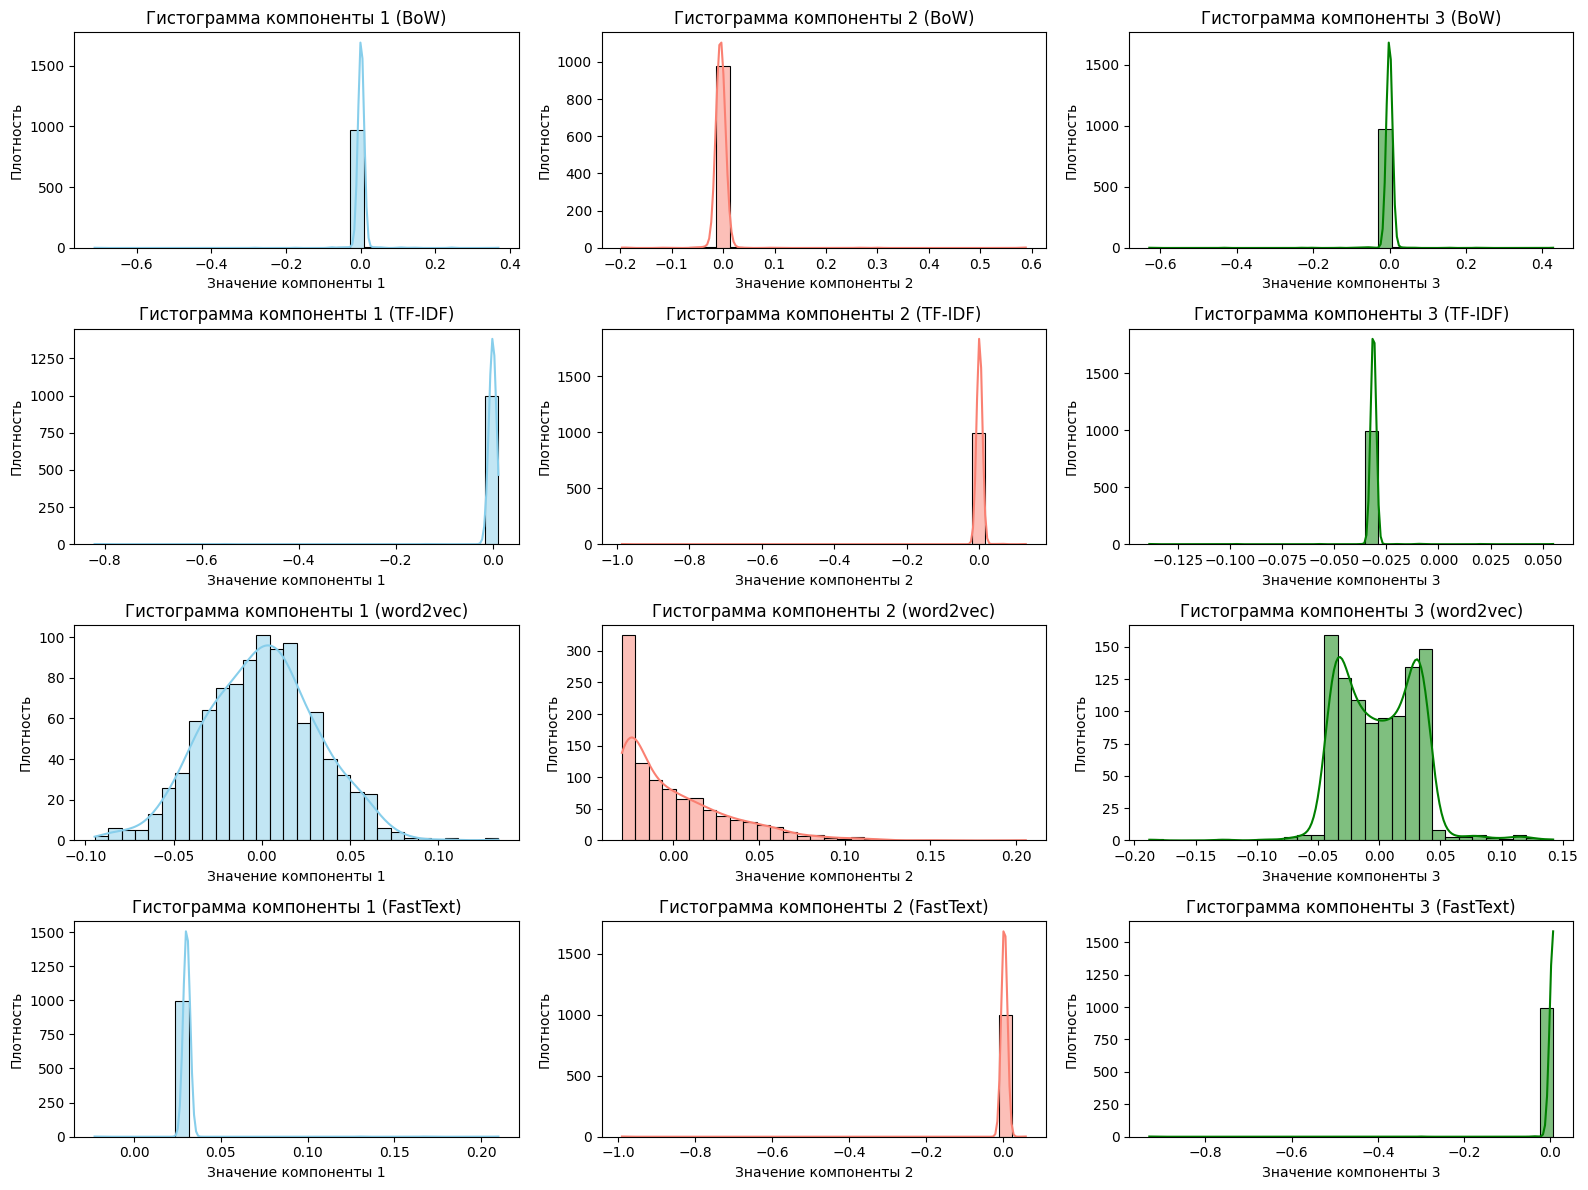

In [192]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(hlle_dict, axs)

## 8) Local Tangent Space Alignment (LTSA)

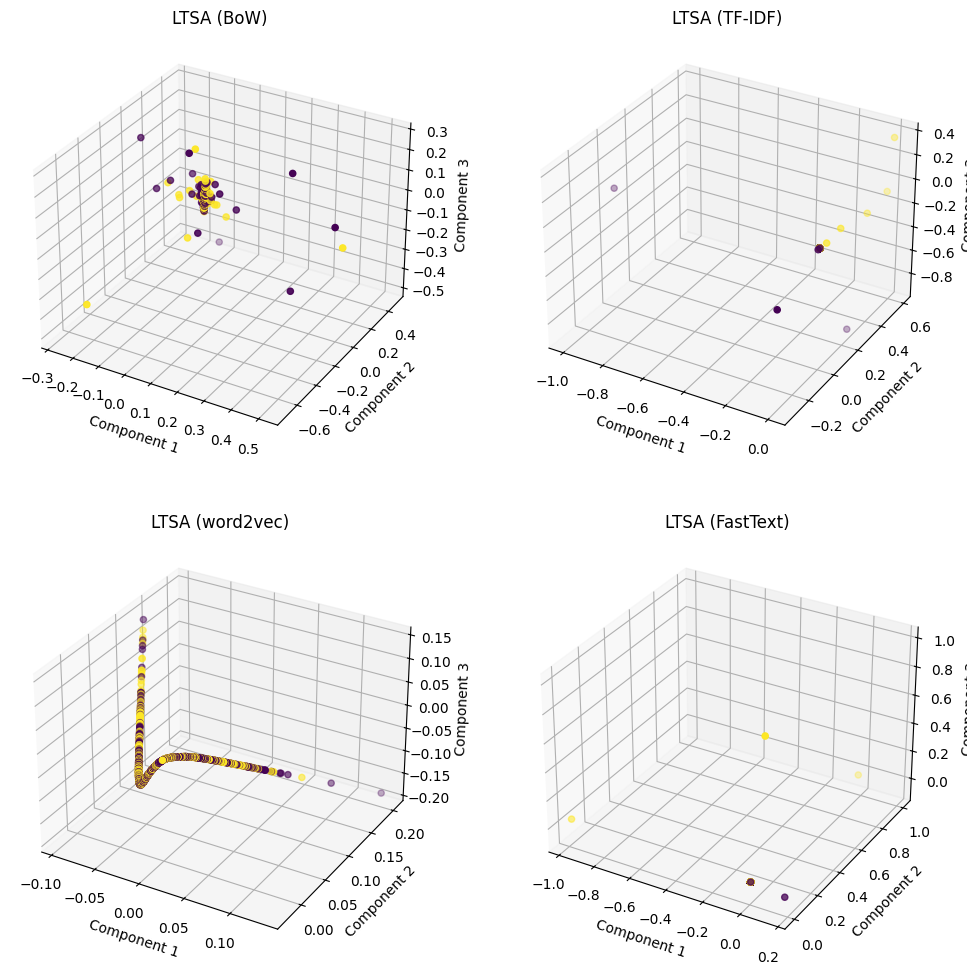

In [193]:
ltsa_dict = {name: LocallyLinearEmbedding(n_components=3, n_neighbors=30, method='ltsa', eigen_solver='dense').fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(ltsa_dict, axs, 'LTSA')

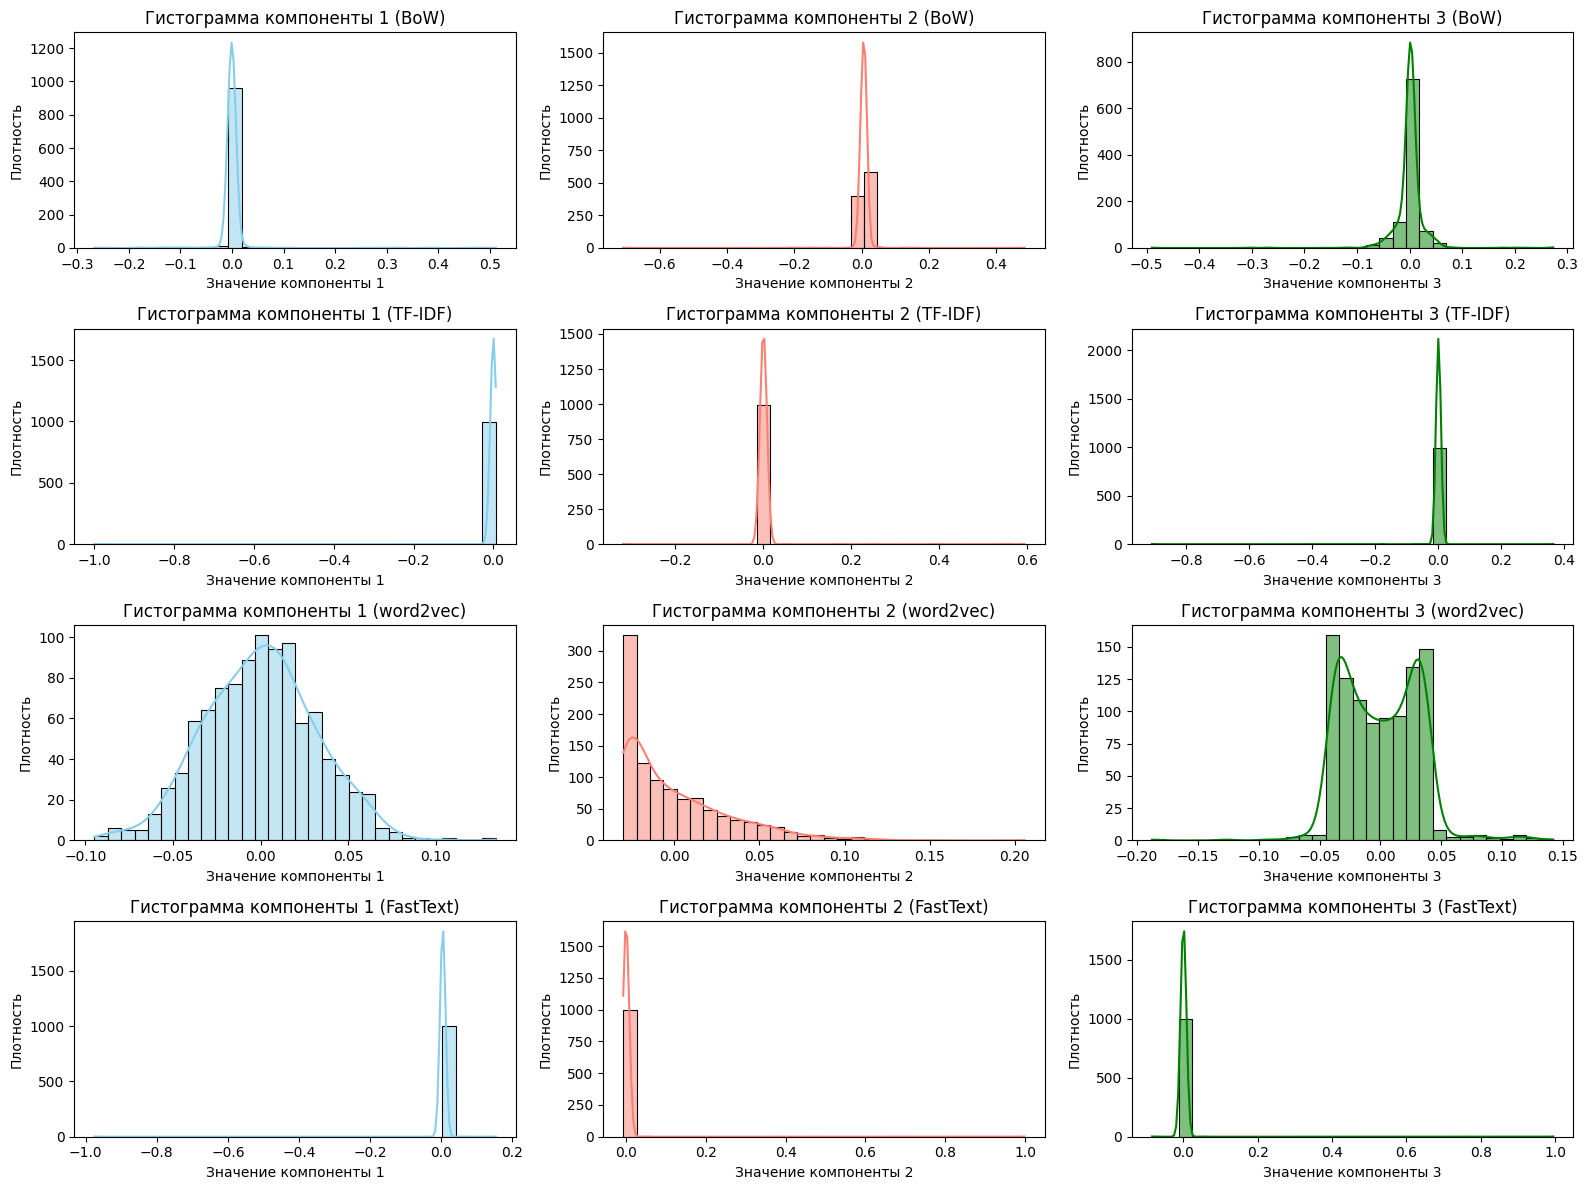

In [194]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(ltsa_dict, axs)

## 9) Spectral Embedding

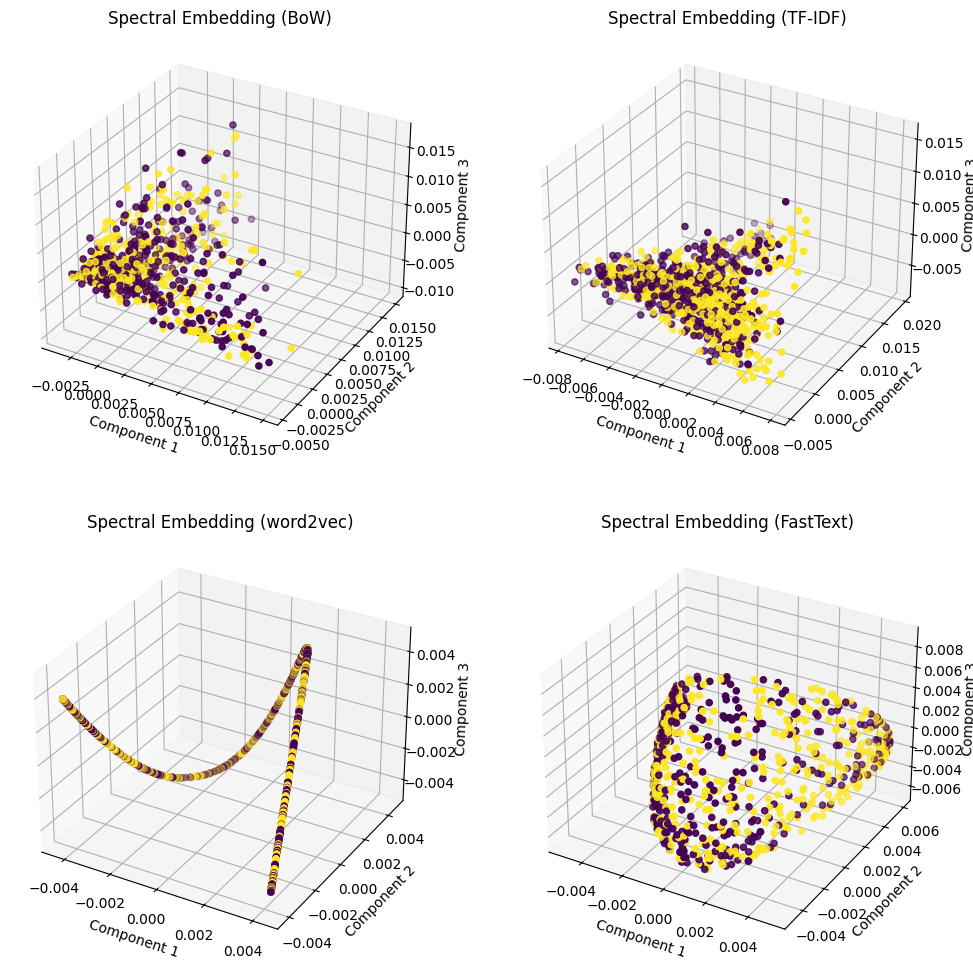

In [195]:
spectral_dict = {name: SpectralEmbedding(n_components=3).fit_transform(data) for name, data in emb_dict.items()}
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
plot_3d(spectral_dict, axs, 'Spectral Embedding')

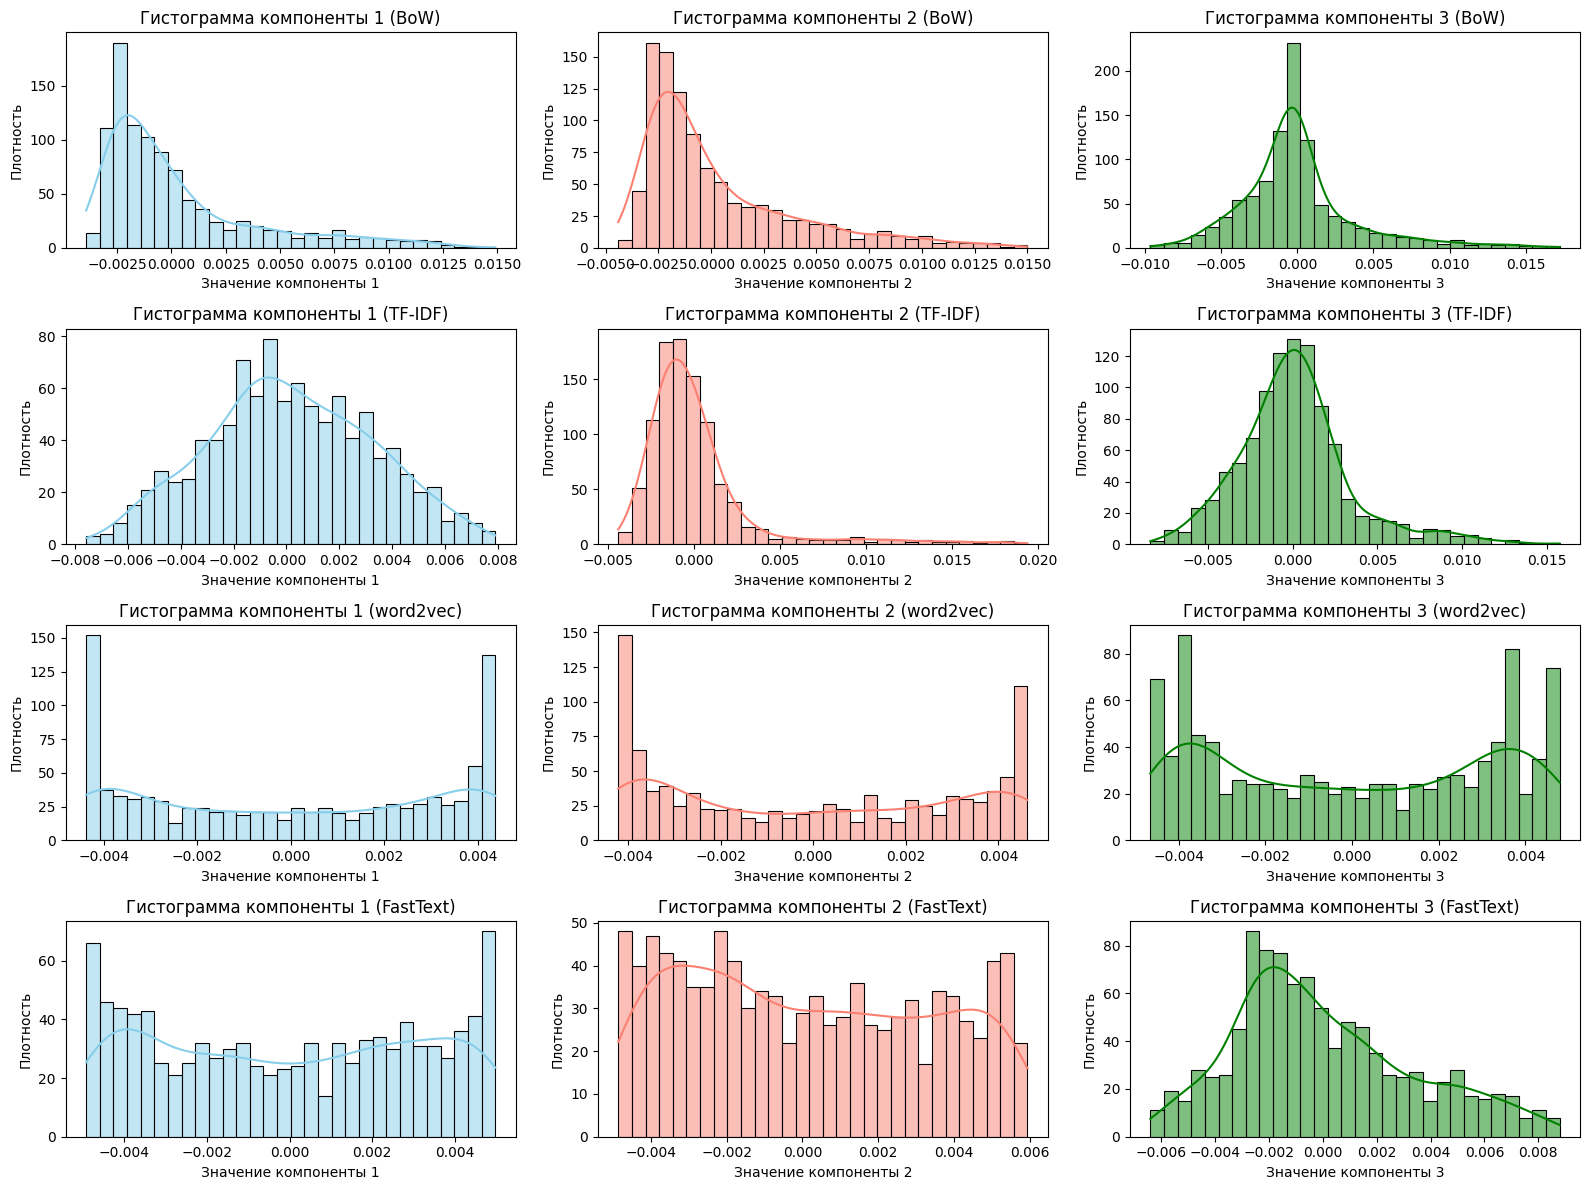

In [196]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_hist(spectral_dict, axs)

## 10) Autoencoder (MLPRegressor)

### 10.1) BoW

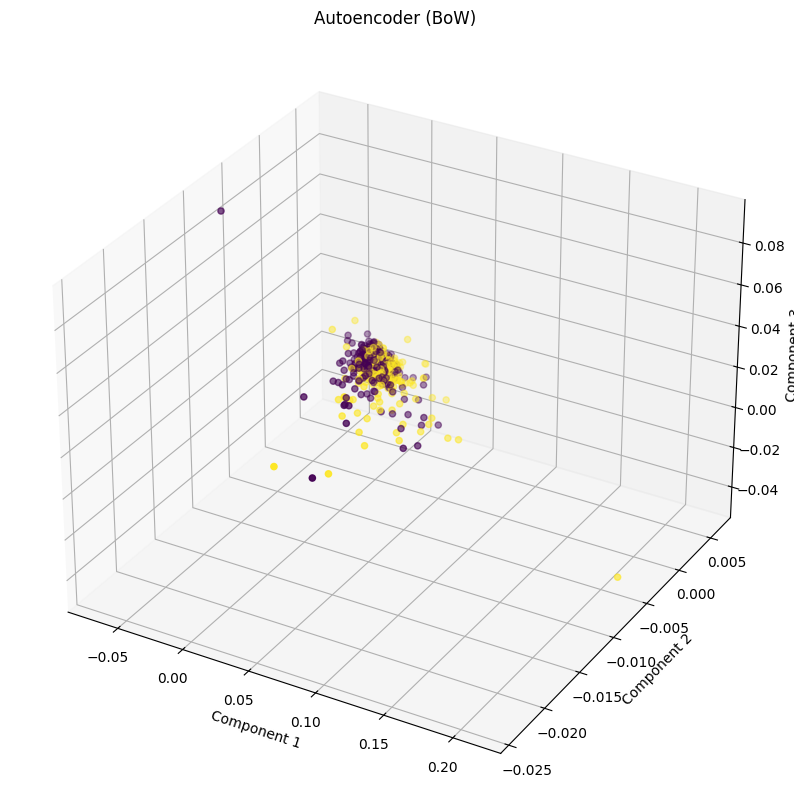

In [197]:
autoencoder = MLPRegressor(hidden_layer_sizes=(3,),  
                           activation='relu',
                           solver='adam',
                           max_iter=1000,
                           random_state=42)

autoencoder.fit(cv_train_reviews, cv_train_reviews)

tr_data = autoencoder.predict(cv_train_reviews)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tr_data[:, 0], tr_data[:, 1], tr_data[:, 2], c=train_sentiments)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Autoencoder (BoW)')
plt.show()

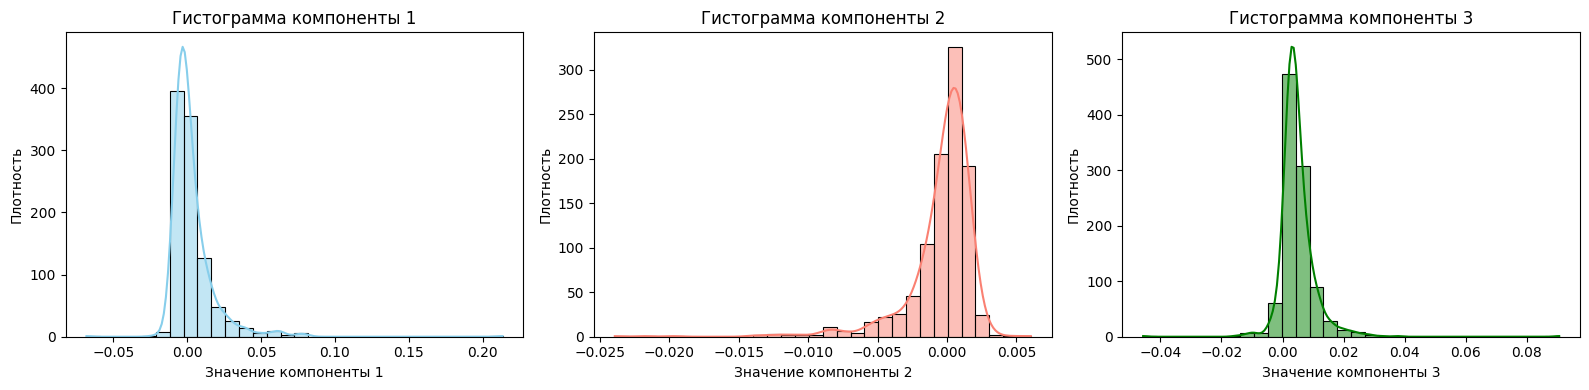

In [198]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(tr_data[:, 0], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Гистограмма компоненты 1')
axes[0].set_xlabel('Значение компоненты 1')
axes[0].set_ylabel('Плотность')

sns.histplot(tr_data[:, 1], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Гистограмма компоненты 2')
axes[1].set_xlabel('Значение компоненты 2')
axes[1].set_ylabel('Плотность')

sns.histplot(tr_data[:, 2], bins=30, ax=axes[2], color='green', kde=True)
axes[2].set_title('Гистограмма компоненты 3')
axes[2].set_xlabel('Значение компоненты 3')
axes[2].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

### 10.2) TF-IDF

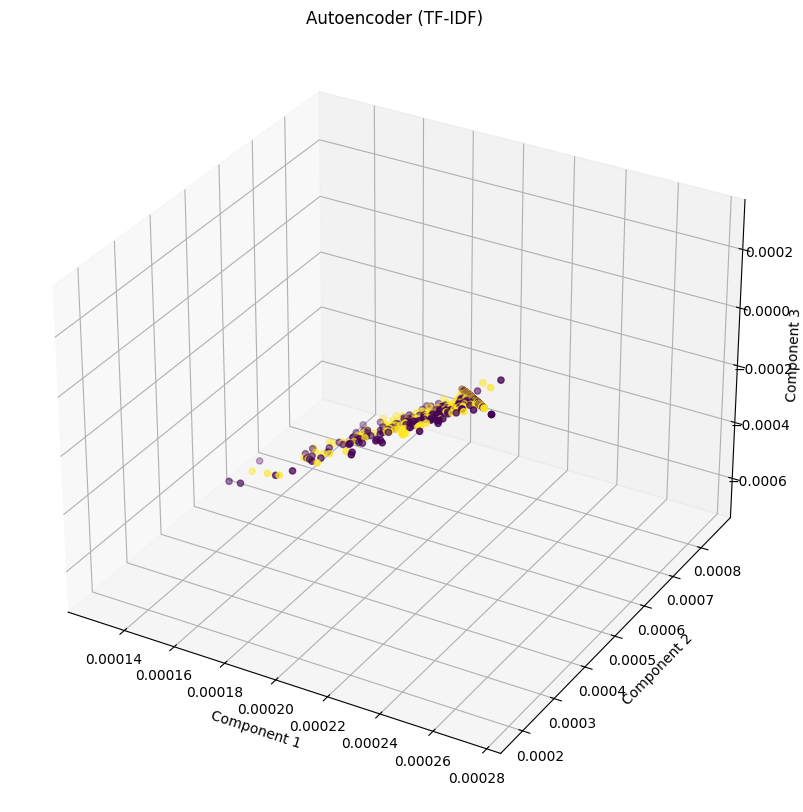

In [199]:
autoencoder = MLPRegressor(hidden_layer_sizes=(3,),  
                           activation='relu',
                           solver='adam',
                           max_iter=1000,
                           random_state=42)

autoencoder.fit(tv_train_reviews, tv_train_reviews)

tr_data = autoencoder.predict(tv_train_reviews)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tr_data[:, 0], tr_data[:, 1], tr_data[:, 2], c=train_sentiments)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Autoencoder (TF-IDF)')
plt.show()

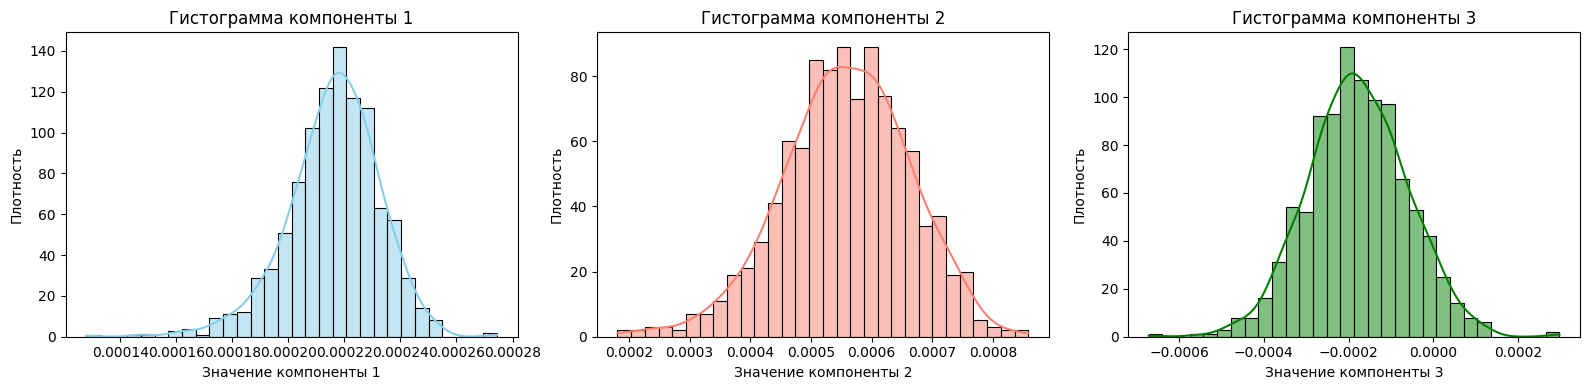

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(tr_data[:, 0], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Гистограмма компоненты 1')
axes[0].set_xlabel('Значение компоненты 1')
axes[0].set_ylabel('Плотность')

sns.histplot(tr_data[:, 1], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Гистограмма компоненты 2')
axes[1].set_xlabel('Значение компоненты 2')
axes[1].set_ylabel('Плотность')

sns.histplot(tr_data[:, 2], bins=30, ax=axes[2], color='green', kde=True)
axes[2].set_title('Гистограмма компоненты 3')
axes[2].set_xlabel('Значение компоненты 3')
axes[2].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

### 10.3) Word2Vec

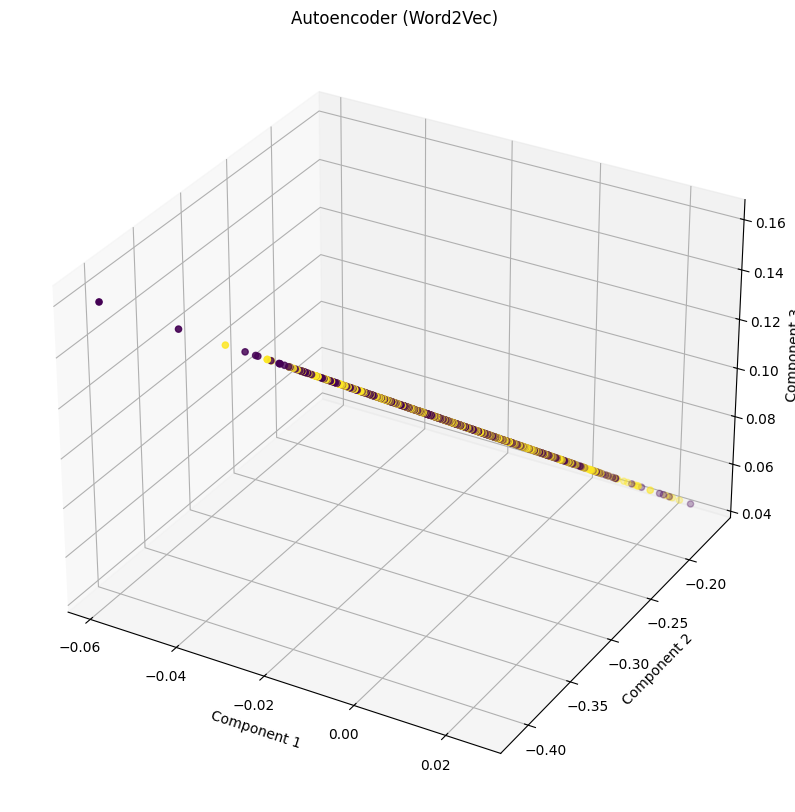

In [201]:
autoencoder = MLPRegressor(hidden_layer_sizes=(3,),  
                           activation='relu',
                           solver='adam',
                           max_iter=1000,
                           random_state=42)

autoencoder.fit(train_word2vec_arrays, train_word2vec_arrays)

tr_data = autoencoder.predict(train_word2vec_arrays)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tr_data[:, 0], tr_data[:, 1], tr_data[:, 2], c=train_sentiments)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Autoencoder (Word2Vec)')
plt.show()

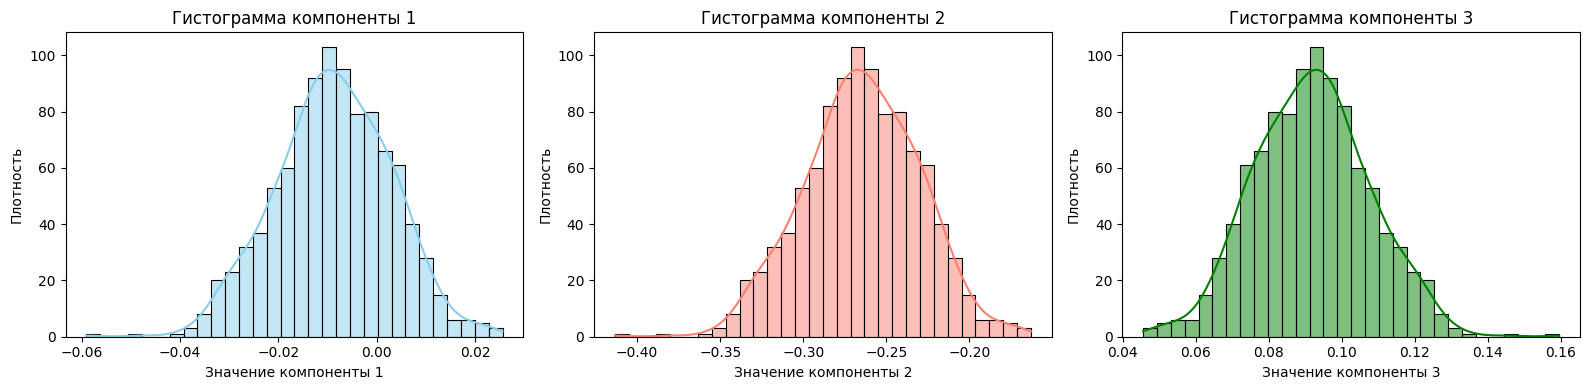

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(tr_data[:, 0], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Гистограмма компоненты 1')
axes[0].set_xlabel('Значение компоненты 1')
axes[0].set_ylabel('Плотность')

sns.histplot(tr_data[:, 1], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Гистограмма компоненты 2')
axes[1].set_xlabel('Значение компоненты 2')
axes[1].set_ylabel('Плотность')

sns.histplot(tr_data[:, 2], bins=30, ax=axes[2], color='green', kde=True)
axes[2].set_title('Гистограмма компоненты 3')
axes[2].set_xlabel('Значение компоненты 3')
axes[2].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

### 10.4) FastText

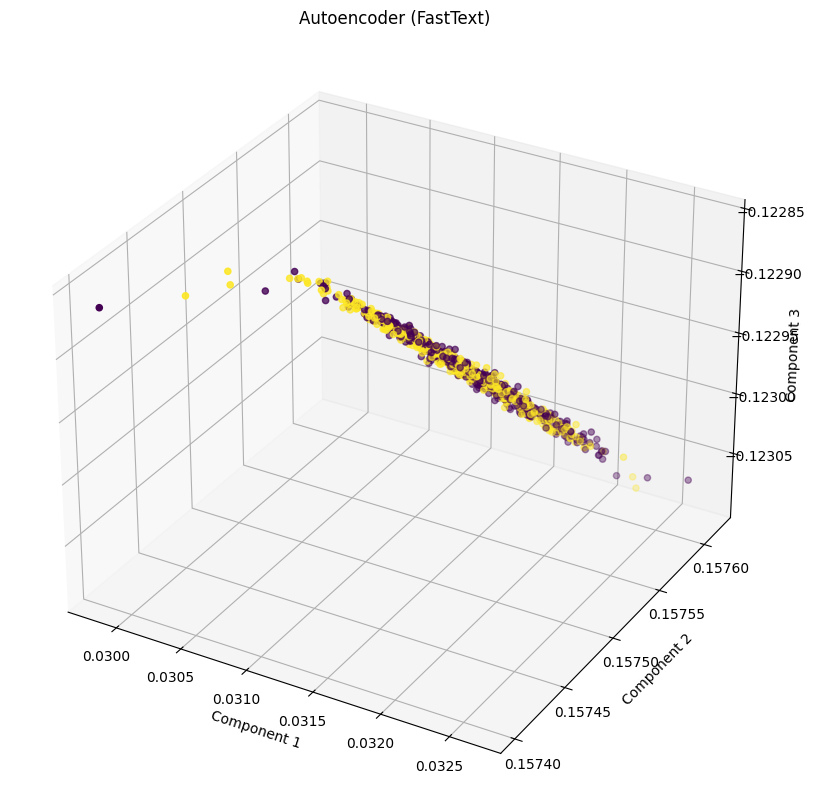

In [203]:
autoencoder = MLPRegressor(hidden_layer_sizes=(3,),  
                           activation='relu',
                           solver='adam',
                           max_iter=1000,
                           random_state=42)

autoencoder.fit(train_fasttext_arrays, train_fasttext_arrays)

tr_data = autoencoder.predict(train_word2vec_arrays)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tr_data[:, 0], tr_data[:, 1], tr_data[:, 2], c=train_sentiments)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('Autoencoder (FastText)')
plt.show()

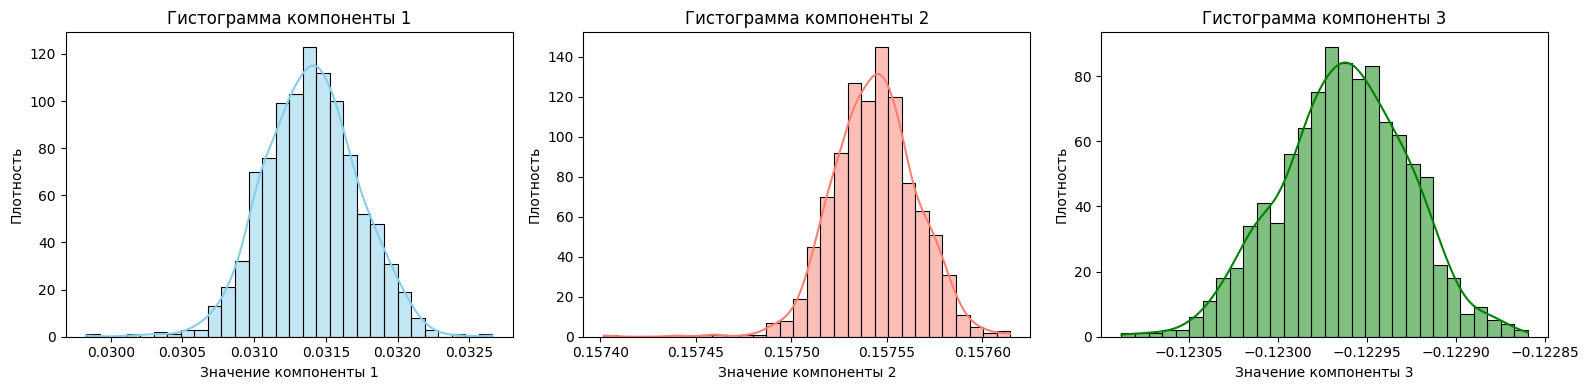

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(tr_data[:, 0], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Гистограмма компоненты 1')
axes[0].set_xlabel('Значение компоненты 1')
axes[0].set_ylabel('Плотность')

sns.histplot(tr_data[:, 1], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Гистограмма компоненты 2')
axes[1].set_xlabel('Значение компоненты 2')
axes[1].set_ylabel('Плотность')

sns.histplot(tr_data[:, 2], bins=30, ax=axes[2], color='green', kde=True)
axes[2].set_title('Гистограмма компоненты 3')
axes[2].set_xlabel('Значение компоненты 3')
axes[2].set_ylabel('Плотность')

plt.tight_layout()
plt.show()